In [12]:
from pathlib import Path
import duckdb
import pandas as pd

data_root = Path("D:\\데이터\\건축데이터 건축허브 개방데이터")
path_DB = data_root / "건축물대장_2025년_02월.db"

건축허브에서 제공하는 건축물대장 데이터를 활용하여 분석

2025년 2월 이전 데이터는 위반건축물 등 일부 건축물이 빠져있는 문제가 있어 부득이 2025년 2월 말 데이터로 2024년 말 기준 건축물 현황을 집계

In [13]:
# Open a DuckDB connection
con = duckdb.connect(database=path_DB, read_only=True)

# print the list of tables in the database
tables = con.execute("SHOW TABLES").fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
    print()

# show heads of the tables
for table in tables:
    table_name = table[0]
    print(f"Head of {table_name}:")
    df = con.execute(f"SELECT * FROM {table_name} LIMIT 5").fetchdf()
    print(df)
    print()

Tables in the database:
기본개요

층별개요

표제부

Head of 기본개요:
  관리_건축물대장_PK 관리_상위_건축물대장_PK 대장_구분_코드 대장_구분_코드_명 대장_종류_코드 대장_종류_코드_명  \
0      100211           None        1         일반        1      총괄표제부   
1      100215           None        1         일반        1      총괄표제부   
2      100216           None        1         일반        1      총괄표제부   
3      100218           None        1         일반        1      총괄표제부   
4      100219           None        1         일반        1      총괄표제부   

                  대지_위치                  도로명_대지_위치  건물_명 시군구_코드  ...  \
0  서울특별시 종로구 관철동 12-1번지   서울특별시 종로구 종로14길 20 (관철동)  None  11110  ...   
1  서울특별시 종로구 청진동 21-1번지  서울특별시 종로구 종로5길 32-6 (청진동)  None  11110  ...   
2  서울특별시 종로구 중학동 16-2번지                       None  None  11110  ...   
3  서울특별시 종로구 중학동 24-1번지      서울특별시 종로구 율곡로 5 (중학동)  None  11110  ...   
4  서울특별시 종로구 중학동 35-1번지                       None  None  11110  ...   

  새주소_지상지하_코드 새주소_본_번 새주소_부_번 지역_코드 지구_코드 구역_코드 지역_코드_명  지구_코드_명 구역_코드_명  \
0  

In [14]:
# Create a list to store the table names and their record counts
table_counts = []

# Iterate through the tables and count the records
for table in tables:
    table_name = table[0]
    count = con.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
    table_counts.append({"Table Name": table_name, "Record Count": count})

# Convert the list to a DataFrame
record_counts_df = pd.DataFrame(table_counts)

# Display the DataFrame
display(record_counts_df)

,Table Name,Record Count
0,기본개요,27994157
1,층별개요,21048715
2,표제부,8027067


In [15]:
# Create a temporary view with the selected columns
층별개요_필터링 = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        "기타_용도"
    FROM 층별개요
""")

In [16]:
# Display the first few rows
층별개요_필터링_df = con.execute("SELECT * FROM 층별개요_필터링 LIMIT 10000").fetchdf()
# Process the DataFrame
filtered_sampled_df = (
    층별개요_필터링_df.drop_duplicates()
    .sort_values(by=["주_용도_코드"])
    .groupby("주_용도_코드")
    .filter(lambda x: len(x) >= 60)  # Drop groups with less rows
    .reset_index(drop=True)
    .groupby("주_용도_코드")
    .apply(lambda x: x.sample(n=5, replace=False, random_state=42))
    .reset_index(drop=True)
)

# Display the processed DataFrame
display(filtered_sampled_df)

# Save the processed DataFrame to a CSV file in the results directory
results_dir = Path("../results")
filtered_sampled_df.to_csv(
    results_dir / "층별개요_용도_기재내용_예시.csv", index=False, encoding="utf-8-sig"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_24712\2096223921.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, replace=False, random_state=42))


,주_용도_코드,주_용도_코드_명,기타_용도
0,01001,단독주택,"주택,소매점"
1,01001,단독주택,주택
2,01001,단독주택,┛
3,01001,단독주택,차고
4,01001,단독주택,창고
5,01003,다가구주택,다가구용주택(2가구)
6,01003,다가구주택,보일러실
7,01003,다가구주택,"단독주택(다가구주택,5가구)"
8,01003,다가구주택,계단실
9,01003,다가구주택,단독주택(다가구주택2가구)


In [17]:
# Perform value count using SQL
value_counts_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        "기타_용도",
        COUNT(*) AS "Count"
    FROM 층별개요_필터링
    GROUP BY "주_용도_코드", "주_용도_코드_명", "기타_용도"
    ORDER BY "Count" DESC
""")

# Fetch and display the result
value_counts_df = value_counts_sql.fetchdf()
display(value_counts_df.head(30))
# Save the top 30 rows to a CSV file
value_counts_df.head(30).to_csv(
    results_dir / "층별개요_용도_기재내용_top30.csv", index=False, encoding="utf-8-sig"
)

,주_용도_코드,주_용도_코드_명,기타_용도,Count
0,01001,단독주택,주택,3192276
1,02001,아파트,아파트,1749831
2,01001,단독주택,단독주택,1568151
3,02001,아파트,공동주택(아파트),703628
4,18001,창고,창고,462082
5,02003,다세대주택,다세대주택,319380
6,03001,소매점,소매점,283287
7,04001,일반음식점,일반음식점,221384
8,21101,축사,축사,219071
9,01003,다가구주택,주택,211141


In [18]:
# Calculate the sum of counts grouped by 주_용도_코드
sum_by_code_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        SUM("Count") AS "Total Count"
    FROM value_counts_sql
    GROUP BY "주_용도_코드", "주_용도_코드_명"
    ORDER BY "Total Count" DESC
""")

# Fetch and display the result
sum_by_code_df = sum_by_code_sql.fetchdf().astype({"Total Count": "int"})
display(sum_by_code_df)

# Save the result to a CSV file
sum_by_code_df.to_csv(
    results_dir / "층_주_용도_코드별_합계.csv", index=False, encoding="utf-8-sig"
)

,주_용도_코드,주_용도_코드_명,Total Count
0,01001,단독주택,6118573
1,02001,아파트,2877653
2,01003,다가구주택,1923975
3,02003,다세대주택,1261033
4,03001,소매점,903494
...,...,...,...
673,14999,None,1
674,24104,수신시설,1
675,Z3006,체육장,1
676,23007,소년분류심사원,1


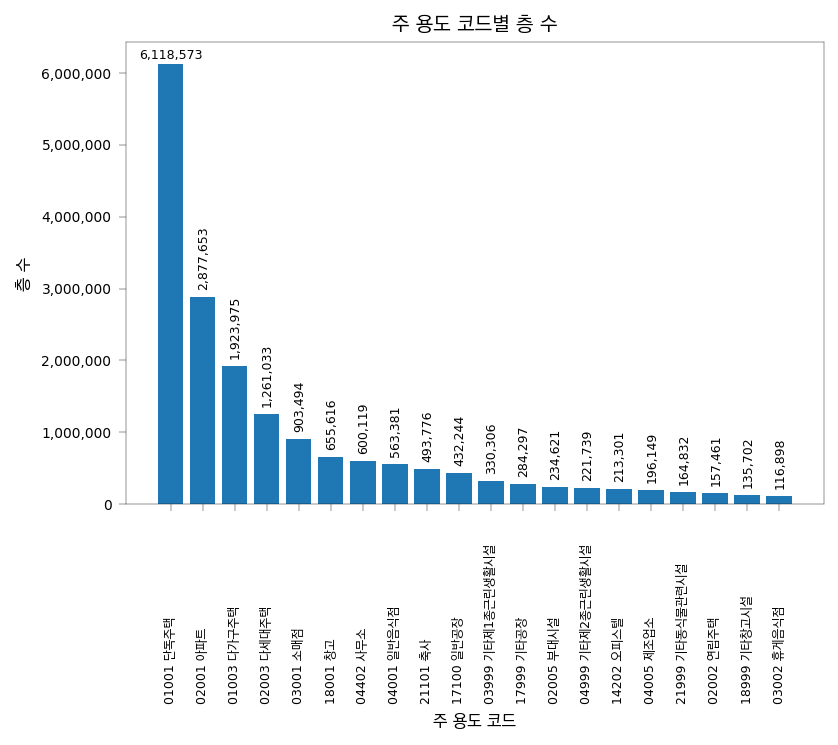

In [19]:
import matplotlib.pyplot as plt

# Apply the custom style
plt.style.use("./auri.mplstyle")

head_df = sum_by_code_df.head(20)

# Plot the bar chart
plt.bar(
    (head_df["주_용도_코드"] + " " + head_df["주_용도_코드_명"]).fillna("(미기재)"),
    head_df["Total Count"],
)
for i, value in enumerate(head_df["Total Count"]):
    if i in [0]:
        plt.text(
            i,
            value + 40000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            # rotation=45,
        )
    if i in range(1, 21):
        plt.text(
            i + 0.03,  # Move text slightly to the right
            value + 100000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            rotation=90,
        )
plt.xlabel("주 용도 코드")
plt.ylabel("층 수")
plt.title("주 용도 코드별 층 수")
plt.ticklabel_format(
    style="plain", axis="y"
)  # Use plain style for full numbers on y-axis
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)  # Format y-axis with commas
plt.xticks(rotation=90, ha="center", va="bottom", fontsize=6)
for lbl in plt.gca().get_xticklabels():
    lbl.set_y(-0.40)
# Save the plot to a file
plt.savefig(results_dir / "층_주_용도_코드별_층_수_막대그래프.png")
# Show the plot
plt.show()

In [20]:
value_counts_df

,주_용도_코드,주_용도_코드_명,기타_용도,Count
0,01001,단독주택,주택,3192276
1,02001,아파트,아파트,1749831
2,01001,단독주택,단독주택,1568151
3,02001,아파트,공동주택(아파트),703628
4,18001,창고,창고,462082
...,...,...,...,...
777845,15201,관광호텔,"기계실,보일러실",1
777846,08007,철도시설,판매시설(305호),1
777847,02001,아파트,"관리사무소,방재실,MDF실,작은도서관,주민교육시설",1
777848,03001,소매점,일용품소매점(농산물공동판매장),1


In [21]:
# Create a temporary view to split the '기타_용도' column into arrays using a regular expression
value_counts_split = con.sql("""
    SELECT 
        *,
        regexp_split_to_array(lower("기타_용도"), '[^\\p{L}\\d]+') AS "기타_용도_분리"
    FROM value_counts_sql
""")

# Fetch and display the result
value_counts_split.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01001,단독주택,주택,3192276,[주택]
1,02001,아파트,아파트,1749831,[아파트]
2,01001,단독주택,단독주택,1568151,[단독주택]
3,02001,아파트,공동주택(아파트),703628,"[공동주택, 아파트, ]"
4,18001,창고,창고,462082,[창고]
...,...,...,...,...,...
777845,24999,기타방송통신시설,식당 및 대회의실,1,"[식당, 및, 대회의실]"
777846,08007,철도시설,"공조실,계단실",1,"[공조실, 계단실]"
777847,08007,철도시설,판매시설(404호),1,"[판매시설, 404호, ]"
777848,10003,학원,"교육연구시설(학원),제1종근,생(의원), 제2종근.생(인터넷컴퓨터게임시설제공업소)",1,"[교육연구시설, 학원, 제1종근, 생, 의원, 제2종근, 생, 인터넷컴퓨터게임시설제..."


In [22]:
# Create a temporary view to split the '기타_용도' column into rows using a regular expression
value_counts_split_table = con.sql("""
    SELECT 
        *,
        regexp_split_to_table(lower("기타_용도"), '[^\\p{L}\\d]+') AS "기타_용도_분리"
    FROM value_counts_sql
""")

# Fetch and display the result
value_counts_split_table.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01001,단독주택,주택,3192276,주택
1,02001,아파트,아파트,1749831,아파트
2,01001,단독주택,단독주택,1568151,단독주택
3,02001,아파트,공동주택(아파트),703628,공동주택
4,02001,아파트,공동주택(아파트),703628,아파트
...,...,...,...,...,...
2481274,02003,다세대주택,"다세대주택:72.04, 주차장:69.51",1,69
2481275,02003,다세대주택,"다세대주택:72.04, 주차장:69.51",1,51
2481276,14299,기타일반업무시설,물탱크(연면적산정시제외),1,물탱크
2481277,14299,기타일반업무시설,물탱크(연면적산정시제외),1,연면적산정시제외


In [23]:
# Group by 주_용도_코드, 주_용도_코드_명, and 기타_용도_분리 and calculate the sum of Count
sum_by_words = con.sql("""
    SELECT 
        "기타_용도_분리",
        SUM("Count") AS "Total Count"
    FROM value_counts_split_table
    GROUP BY "기타_용도_분리"
    ORDER BY "Total Count" DESC
""")
# Drop rows where "기타_용도_분리" is empty
sum_by_words = sum_by_words.filter(
    "기타_용도_분리 IS NOT NULL AND 기타_용도_분리 != ''"
)
# Fetch and display the result
sum_by_words_df = sum_by_words.fetchdf().astype({"Total Count": "int"})
display(sum_by_words_df.head(30))

# Save the result to a CSV file
sum_by_words_df.to_csv(
    results_dir / "층_기타_용도_단어별_합계_중복포함.csv",
    index=False,
    encoding="utf-8-sig",
)

,기타_용도_분리,Total Count
0,주택,3857882
1,아파트,2584109
2,단독주택,2217159
3,창고,1067948
4,공동주택,1005215
5,다가구주택,982559
6,다세대주택,850405
7,제2종근린생활시설,803173
8,소매점,611069
9,계단실,592979


In [24]:
value_counts_split_table.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01001,단독주택,주택,3192276,주택
1,02001,아파트,아파트,1749831,아파트
2,01001,단독주택,단독주택,1568151,단독주택
3,02001,아파트,공동주택(아파트),703628,공동주택
4,02001,아파트,공동주택(아파트),703628,아파트
...,...,...,...,...,...
2481274,18001,창고,창고(72.26㎡)/계단실(11.88㎡),1,
2481275,17999,기타공장,"계단및E,V실(면적제외)",1,계단및e
2481276,17999,기타공장,"계단및E,V실(면적제외)",1,v실
2481277,17999,기타공장,"계단및E,V실(면적제외)",1,면적제외


In [25]:
# Select one distinct record for each 기타_용도_분리
distinct_record_sql = con.sql("""
    SELECT DISTINCT ON ("기타_용도_분리") 
        "기타_용도_분리", 
        "기타_용도",
        "주_용도_코드", 
        "주_용도_코드_명"
    FROM value_counts_split_table
    WHERE "기타_용도_분리" IS NOT NULL AND "기타_용도_분리" != ''
    ORDER BY "Count" DESC
""")

# Fetch and display the result
distinct_record_df = distinct_record_sql.fetchdf()
display(distinct_record_df)


,기타_용도_분리,기타_용도,주_용도_코드,주_용도_코드_명
0,주택,주택,01001,단독주택
1,아파트,아파트,02001,아파트
2,단독주택,단독주택,01001,단독주택
3,공동주택,공동주택(아파트),02001,아파트
4,창고,창고,18001,창고
...,...,...,...,...
123560,지사관사,지사관사,01001,단독주택
123561,콘크리트수조,"펌프실, 콘크리트수조",03999,기타제1종근린생활시설
123562,농촌체험장기자재창고,제1종근린생활시설(농촌체험장기자재창고),03999,기타제1종근린생활시설
123563,소화벨브실,소화벨브실,17100,일반공장


In [26]:
# top 30 from grouped_sum
top_words_df = sum_by_words_df.head(30)

# join it with distinct_record_sql in sql
usage_sample_sql = con.sql("""
    SELECT 
        t."기타_용도_분리",
        t."Total Count",
        d."기타_용도",
        d."주_용도_코드",
        d."주_용도_코드_명"
    FROM top_words_df t
    JOIN distinct_record_sql d 
    ON t."기타_용도_분리" = d."기타_용도_분리"
    ORDER BY t."Total Count" DESC
""")
# Fetch and display the result
usage_sample_df = usage_sample_sql.fetchdf()
display(usage_sample_df)

# Save the result to a CSV file
usage_sample_df.to_csv(
    results_dir / "층_기타_용도_단어별_합계_중복포함_예시.csv",
    index=False,
    encoding="utf-8-sig",
)

,기타_용도_분리,Total Count,기타_용도,주_용도_코드,주_용도_코드_명
0,주택,3857882,주택,01001,단독주택
1,아파트,2584109,아파트,02001,아파트
2,단독주택,2217159,단독주택,01001,단독주택
3,창고,1067948,창고,18001,창고
4,공동주택,1005215,공동주택(아파트),02001,아파트
5,다가구주택,982559,다가구주택,01003,다가구주택
6,다세대주택,850405,다세대주택,02003,다세대주택
7,제2종근린생활시설,803173,제2종근린생활시설(사무소),04402,사무소
8,소매점,611069,소매점,03001,소매점
9,계단실,592979,계단실,01003,다가구주택


In [27]:
value_counts_split_table

┌──────────────┬─────────────────┬──────────────────┬─────────┬────────────────┐
│ 주_용도_코드 │ 주_용도_코드_명 │    기타_용도     │  Count  │ 기타_용도_분리 │
│   varchar    │     varchar     │     varchar      │  int64  │    varchar     │
├──────────────┼─────────────────┼──────────────────┼─────────┼────────────────┤
│ 01001        │ 단독주택        │ 주택             │ 3192276 │ 주택           │
│ 02001        │ 아파트          │ 아파트           │ 1749831 │ 아파트         │
│ 01001        │ 단독주택        │ 단독주택         │ 1568151 │ 단독주택       │
│ 02001        │ 아파트          │ 공동주택(아파트) │  703628 │ 공동주택       │
│ 02001        │ 아파트          │ 공동주택(아파트) │  703628 │ 아파트         │
│ 02001        │ 아파트          │ 공동주택(아파트) │  703628 │                │
│ 18001        │ 창고            │ 창고             │  462082 │ 창고           │
│ 02003        │ 다세대주택      │ 다세대주택       │  319380 │ 다세대주택     │
│ 03001        │ 소매점          │ 소매점           │  283287 │ 소매점         │
│ 04001        │ 일반음식점      │ 일반음식점       │  221384 │ 일반음식점     

In [29]:
# Create a temporary view grouped_df by grouping and summing the counts
sum_by_code_words_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        FIRST("주_용도_코드_명") AS "주_용도_코드_명",
        "기타_용도_분리",
        SUM("Count") AS "Total Count"
    FROM value_counts_split_table
    WHERE "기타_용도_분리" IS NOT NULL AND "기타_용도_분리" != ''
    GROUP BY "주_용도_코드", "기타_용도_분리"
    ORDER BY "Total Count" DESC;
""")

# Fetch and display the result
sum_by_code_words_df = sum_by_code_words_sql.fetchdf().astype({"Total Count": "int"})
display(sum_by_code_words_df)

# Save the result to a CSV file
sum_by_code_words_df.to_csv(
    results_dir / "층_주_용도_코드별_기타_용도_단어별_합계.csv",
    index=False,
    encoding="utf-8-sig",
)

,주_용도_코드,주_용도_코드_명,기타_용도_분리,Total Count
0,01001,단독주택,주택,3304862
1,02001,아파트,아파트,2578652
2,01001,단독주택,단독주택,1850839
3,01003,다가구주택,다가구주택,964535
4,02003,다세대주택,다세대주택,818436
...,...,...,...,...
336653,03999,기타제1종근린생활시설,쌍절각,1
336654,11999,기타노유자시설,노인,1
336655,03199,기타공공시설,경비실등,1
336656,02001,아파트,건강관리센터,1


In [31]:
# Pivot the data
pivot_df = sum_by_code_words_df.pivot_table(
    index="주_용도_코드",
    columns="기타_용도_분리",
    values="Total Count",
    aggfunc="sum",
    fill_value=0,
)
# Limit the pivot table to the top 30 rows and columns based on Total Count
top_columns = (
    sum_by_code_words_df.groupby("기타_용도_분리")["Total Count"]
    .sum()
    .nlargest(10)
    .index
)

pivot_df = pivot_df.loc[:, top_columns]

# Sort the pivot table by the index
pivot_df = pivot_df.sort_index()
pivot_df = pivot_df.loc[
    :,
    pivot_df.sum(axis=0).sort_values(ascending=False).index,
]

# select rows with sum > 1000
pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > 1000]

# Add the 주_용도_코드_명 as a label column
pivot_df.insert(
    0,
    "주_용도_코드_명",
    sum_by_code_words_df.drop_duplicates("주_용도_코드").set_index("주_용도_코드")[
        "주_용도_코드_명"
    ],
)

# Display the pivot table
display(pivot_df)

# Save the pivot table to a CSV file
pivot_df.to_csv(
    results_dir / "층_주_용도_코드별_상위_단어별_빈도_pivot.csv",
    index=True,
    encoding="utf-8-sig",
)

기타_용도_분리,주_용도_코드_명,주택,아파트,단독주택,창고,공동주택,다가구주택,다세대주택,제2종근린생활시설,소매점,계단실
주_용도_코드,,,,,,,,,,,
01000,단독주택,5598,0,787,1240,0,111,8,2,4,13
01001,단독주택,3304862,14,1850839,248983,90,16355,1283,718,3795,23325
01002,다중주택,2868,55,24639,154,49,32,16,15,34,9101
01003,다가구주택,443844,300,335083,13907,883,964535,28517,377,888,154179
02000,공동주택,286,376,9,3,324,0,112,1,1,16
...,...,...,...,...,...,...,...,...,...,...,...
20999,기타자동차관련시설,12,0,1,674,0,0,0,31,16,389
21101,축사,338,0,107,22445,0,1,0,9,2,31
21204,가축용창고,0,0,0,2375,0,0,0,0,0,0


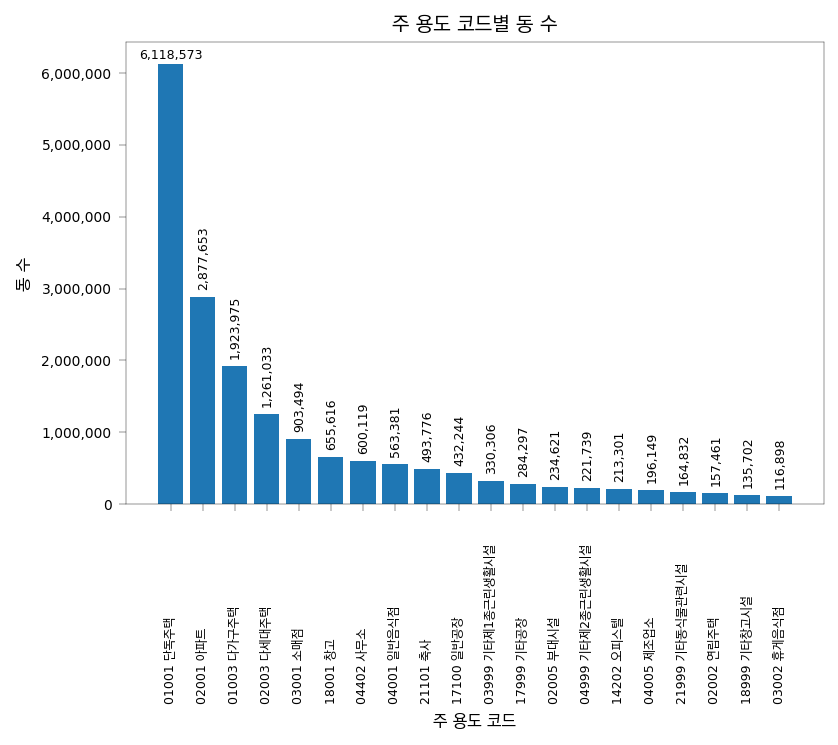

In [32]:
import matplotlib.pyplot as plt

# Apply the custom style
plt.style.use("./auri.mplstyle")

head_df = sum_by_code_df.head(20)

# Plot the bar chart
plt.bar(
    (head_df["주_용도_코드"] + " " + head_df["주_용도_코드_명"]).fillna("(미기재)"),
    head_df["Total Count"],
)
for i, value in enumerate(head_df["Total Count"]):
    if i in [0]:
        plt.text(
            i,
            value + 40000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            # rotation=45,
        )
    if i in range(1, 21):
        plt.text(
            i + 0.03,  # Move text slightly to the right
            value + 100000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            rotation=90,
        )
plt.xlabel("주 용도 코드")
plt.ylabel("동 수")
plt.title("주 용도 코드별 동 수")
plt.ticklabel_format(
    style="plain", axis="y"
)  # Use plain style for full numbers on y-axis
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)  # Format y-axis with commas
plt.xticks(rotation=90, ha="center", va="bottom", fontsize=6)
for lbl in plt.gca().get_xticklabels():
    lbl.set_y(-0.40)
# Save the plot to a file
plt.savefig(results_dir / "층_주_용도_코드별_동_수_막대그래프.png")
# Show the plot
plt.show()